## ANOVA using Python

Jupyter Notebook for the blog post [Three ways to do a two-way ANOVA with Python](https://www.marsja.se/three-ways-to-carry-out-2-way-anova-with-python/). Note in this Python ANOVA tutorial only two of the examples are covered; "pure Python ANOVA" and ANOVA using Statsmodels. 

There are two custom functions on how to calculate effect sizes (omega and eta squared) also.


First we import all the needed methods:

In [1]:
import pandas as pd 
from statsmodels.formula.api import ols 
from statsmodels.stats.anova import anova_lm 
from statsmodels.graphics.factorplots import interaction_plot 
import matplotlib.pyplot as plt 
from scipy import stats

Next thing is to use Pandas read_csv to load the dataframe. See my [Pandas dataframe tutorial}(https://www.marsja.se/pandas-dataframe-read-csv-excel-subset/) to learn more about working with the dataframe object.

In [2]:
# Loading from URL. Can be loaded from hard drive, also (see above link)
datafile = "https://vincentarelbundock.github.io/Rdatasets/csv/datasets/ToothGrowth.csv" 
data = pd.read_csv(datafile)

Next thing is to carry out some basic data visualization to explore the data. In this example, we use the interaction_plot function to visualize data in Python.

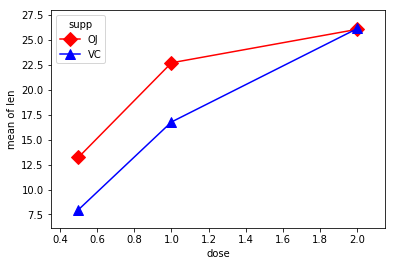

In [3]:
fig = interaction_plot(data.dose, data.supp, data.len, 
                       colors=['red','blue'], markers=['D','^'], ms=10)

## Calculating the Sum of Squares for ANOVA using Python
In the first example we are going to do all calculations using only Python and Pandas.

In [4]:
N = len(data.len)
df_a = len(data.supp.unique()) - 1
df_b = len(data.dose.unique()) - 1
df_axb = df_a*df_b 
df_w = N - (len(data.supp.unique())*len(data.dose.unique()))

### Calculating the grand mean and Sum of Squares A in Python
Next, we are calculating the grand mean and the Sum of Squares A (supp, in this case):

In [5]:
grand_mean = data['len'].mean()
ssq_a = sum([(data[data.supp ==l].len.mean()-grand_mean)**2
             for l in data.supp])

### Calculating Sum of Squares B in Python
Next thing is to use Python to calculate Sum of Squares B:

In [6]:
ssq_b = sum([(data[data.dose ==l].len.mean()-grand_mean)**2 
             for l in data.dose])

### Sum of Squares Total for the ANOVA
We continue by calculating Sum of Squares Total:
    

In [7]:
ssq_t = sum((data.len - grand_mean)**2)

### Sum of Squares Within (error/residual)
Now we continue with calculating the Sum of Squares Within.
We start by subsetting the two levels to calculate the mean of each factor. When this is done we calculate the sum of squares for the residual:

In [8]:
vc = data[data.supp == 'VC']
oj = data[data.supp == 'OJ']
vc_dose_means = [vc[vc.dose == d].len.mean() for d in vc.dose]
oj_dose_means = [oj[oj.dose == d].len.mean() for d in oj.dose]
ssq_w = sum((oj.len - oj_dose_means)**2) +sum((vc.len - vc_dose_means)**2)

### Sum of Squares for the Interaction Term
Finally, we will calculate the Sum of squares for the interaction term:

In [9]:
ssq_axb = ssq_t-ssq_a-ssq_b-ssq_w

## Mean Square Error for the ANOVA Calculation
We will continue by calculating the mean square errors (A, B, Interaction, and residual/error)

In [10]:
# Mean Square Error A
ms_a = ssq_a/df_a

# Mean Square Error B
ms_b = ssq_b/df_b

# Mean Square Error AxB (interaction)
ms_axb = ssq_axb/df_axb

# Mean Square Error Within/Residual
ms_w = ssq_w/df_w

## Calculating the F-statistics using Python (for the Python ANOVA)
Now we can calculate the f-statistics for our terms. That is, we are ready to get to the "fun" part of the Python ANOVA:

In [11]:
f_a = ms_a/ms_w
f_b = ms_b/ms_w
f_axb = ms_axb/ms_w

## Getting P-values for the Python ANOVA
We need to get the p-values to see if any staistical significant effects:

In [12]:
p_a = stats.f.sf(f_a, df_a, df_w) 
p_b = stats.f.sf(f_b, df_b, df_w) 
p_axb = stats.f.sf(f_axb, df_axb, df_w)

## ANOVA table using Python
Now that we have our ANOVA carried out using Python we are going to put everything together in a nice table! 

In [13]:
results = {'sum_sq':[ssq_a, ssq_b, ssq_axb, ssq_w],
           'df':[df_a, df_b, df_axb, df_w],
           'F':[f_a, f_b, f_axb, 'NaN'],
            'PR(>F)':[p_a, p_b, p_axb, 'NaN']}
columns=['sum_sq', 'df', 'F', 'PR(>F)']

aov_table1 = pd.DataFrame(results, columns=columns,
                          index=['supp', 'dose', 
                          'supp:dose', 'Residual'])

aov_table1

sum_sq  df        F       PR(>F)
supp        205.350000   1   15.572  0.000231183
dose       2426.434333   2       92  4.04629e-18
supp:dose   108.319000   2  4.10699    0.0218603
Residual    712.106000  54      NaN          NaN

## How to calculate effect sizes using Python:

We may want to calculate the size of the effects. I have created two functions to calculate eta and omega squared.

In [14]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov


eta_squared(aov_table1)
omega_squared(aov_table1)
print(aov_table1)

                sum_sq  df        F       PR(>F)    eta_sq  omega_sq
supp        205.350000   1   15.572  0.000231183  0.059484  0.055452
dose       2426.434333   2       92  4.04629e-18  0.702864  0.692579
supp:dose   108.319000   2  4.10699    0.0218603  0.031377  0.023647
Residual    712.106000  54      NaN          NaN       NaN       NaN


## Two-way ANOVA using Statsmodels
The above calculations are, of course, much easier to do using the Python package Statsmodels:

In [15]:
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table)


                      sum_sq    df          F        PR(>F)    eta_sq  \
C(supp)           205.350000   1.0  15.571979  2.311828e-04  0.059484   
C(dose)          2426.434333   2.0  91.999965  4.046291e-18  0.702864   
C(supp):C(dose)   108.319000   2.0   4.106991  2.186027e-02  0.031377   
Residual          712.106000  54.0        NaN           NaN       NaN   

                 omega_sq  
C(supp)          0.055452  
C(dose)          0.692579  
C(supp):C(dose)  0.023647  
Residual              NaN  


That was it! Two ways to carry out ANOVA using Python 3.